<h1><center>Exploration of Index Price Distribution and Normality</center></h1>

Begin by importing required packages

Note, the **IBKR TWS API** source packages are open source and can be downloaded here: https://interactivebrokers.github.io/ <br>
The documentation <sup>5</sup> and source packages are hosted on github.

In [28]:
from datetime import datetime, timedelta
from typing import List
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker  # FOr trying to use axis locator, uncluttered x axis
from time import sleep
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd
import sqlalchemy
import numpy as np
import scipy as sp
import scipy.stats
# from statsmodels.stats import shapiro
import ibapi
from ibapi.common import *  # For building IBKR bar data objects, from: https://interactivebrokers.github.io/
from configparser import ConfigParser
import matplotlib.dates as mdates

## Data Retrieval 

### Using the IBKR TWS API to retrieve historical bar data

As mentioned above, the historical market data of the indices was obtained via the IBKR TWS API. The script **historical-data-collector.py** was created to do this. It primarily makes use of the ibapi function reqHistoricalData(). In addition, it takes into consideration the input format required by the IBKR API and some other requirements of this API. <br><br>
After obtaining the raw data, this data was stored in a postgreSQL database. The module **psycopg2** was used to insert the data to the database using python. Then, the data can be retrieved using sqlalchemy as will be shown below.

Since our candlestick data is saved in standard IBKR format, we will define timedeltas for standard bar lengths and total durations<sup>5</sup> -

In [2]:
durationArray = [("S", timedelta(seconds=1)), ("D", timedelta(days=1)), ("W", timedelta(weeks=1)),
                 ("M", timedelta(days=30)), ("Y", timedelta(days=365))]

outerSwitch = {
    "secs": timedelta(seconds=1),
    "mins": timedelta(minutes=1),
    "hours": timedelta(hours=1),
    "day": timedelta(days=1),
    "week": timedelta(weeks=1),
    "month": timedelta(days=30),
    "S": timedelta(seconds=1),
    "D": timedelta(days=1),
    "W": timedelta(weeks=1),
    "M": timedelta(days=30),
    "Y": timedelta(days=365)
}

<br>Then connect to database using **sqlalchemy** and retrieve *bardata* table

In [3]:
parser = ConfigParser()
_ = parser.read('nb.cfg')  # Get postgreSQL DB credentials

In [4]:
engine = sqlalchemy.create_engine(parser.get('my_db', 'conn_string'))
sql_data = pd.read_sql_table('bardata', engine)

## Data Cleaning and Initial Visualization

First, check for null values in data

In [5]:
sql_data.isnull().values.any()

False

As can be seen above there are no null or Nan values in our dataframe. This can be expected for a robust data retrieval tool such as the IBKR TWS API. 

We will further check for "bad" data or outliers by creating a time-series plot for our price data.<br>
In order to account for all bar price values, we will plot the average, where avg_price = (open + high + low + close) / 4. This is one of the price calculations typically used for creating moving averages<sup>2</sup>

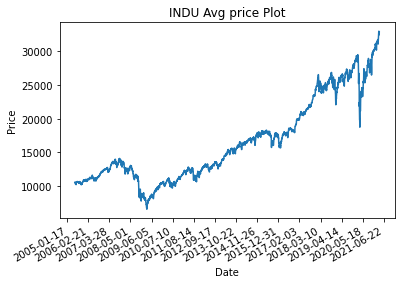

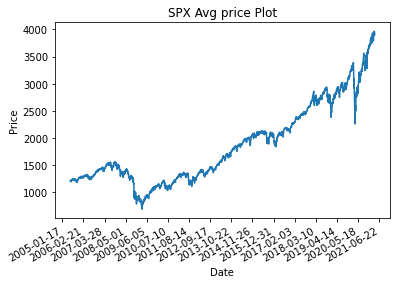

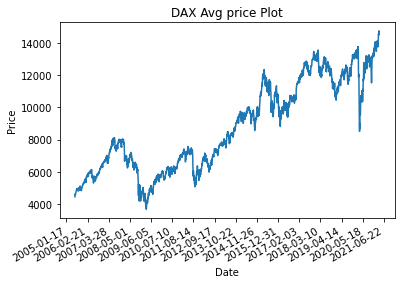

In [6]:
import warnings
warnings.filterwarnings('ignore')  # to supress pandas warning

for symbol in sql_data['symbol'].unique().tolist():
    bars_grouped = sql_data[sql_data['symbol'] == symbol]
    bars_grouped.reset_index(drop = True, inplace = True)
    operation = (bars_grouped.loc[:, 'open'] + bars_grouped.loc[:, 'high'] + bars_grouped.loc[:, 'low'] + bars_grouped.loc[:, 'close']) / 4
    operation.reset_index(drop = True, inplace = True)
    bars_grouped.loc[:, 'calc_price'] = operation
    
    fig, ax = plt.subplots()  # subplots() without arguments returns a Figure and a single Axes.
    ax.plot(bars_grouped['time'], bars_grouped['calc_price'])
    loc = plticker.MultipleLocator(base=400.0)
    ax.xaxis.set_major_locator(loc)
    fig.autofmt_xdate()
    tTitleStr = symbol.strip() + " Avg price Plot"
    ax.set(title=tTitleStr, xlabel="Date", ylabel="Price")
    plt.show()

As can be seen above, the time series plots for the different indices are similar in shape, where overall there is continued growth. They also share common dips, such as after the start of the COVID pandemic. <br>
As such, visually, we do not see any major outliers or erroneous data

## Data Preprocessing

### Data Transformation

Then get a list of all unique index symbols in the database to initialize the bar collection list and map to dict

In [7]:
symbols = sql_data['symbol'].unique().tolist()
barCollection = []
xAxisDates = []
symbolsMap = {}
dailyBarSizeString = "1 day"
utcString = "00:00"

n = 0
for symbol in symbols:  # Initialize bar collection and xAxisDates
    barCollection.append([])
    xAxisDates.append([])
    symbolsMap[symbol.strip()] = n  # Map index symbols to index for bar collection
    n = n + 1
invertSymbolsMap = {v: k for k, v in symbolsMap.items()}  # Invert dict for easier use later

Then, iterate through the table, row by row, and recreate the orignal candlesticks using the barData (IBKR) format

In [8]:
for index, row in sql_data.iterrows():
    rowBar = BarData()

    # Times MUST be given in UTC. (ex expected timestring per ibkr barData format: 2021-03-15 00:00:00+00:00
    splitTimeDate = str(row['time']).split(" ")  # Splits date and time parts of time string
    splitTimestampTmz = str(row['time']).split("+")  # Splits timestamp and time zone, tmz-free timestamp used for bar
    splitTimeTmz = splitTimeDate[1].split("+")  # Splits time and time zone

    if splitTimeTmz[1] != utcString:
        print("Time NOT given in UTC, stopping")
        break

    # In this case only insert date part into BarData, since that's how daily bars given
    barDate = splitTimeDate[0]
    barDate = "".join(barDate.split("-"))  # Get date in %Y%m%d format as expected
    if (str(row['bar_size'])).strip() != dailyBarSizeString:  # strip trailing whitespace from bar size
        barDate = " ".join((barDate, splitTimeTmz[0]))  # If NOT daily, insert whole timestamp w/out tmz

    rowBar.date = barDate
    rowBar.open = row['open']
    rowBar.high = row['high']
    rowBar.low = row['low']
    rowBar.close = row['close']
    rowBar.volume = row['volume']
    rowBar.barCount = row['count']
    rowBar.average = row['vwap']

    currCollectionIndex = symbolsMap.get(row['symbol'].strip())  # Again take off whitespace
    barCollectionItem = barCollection[currCollectionIndex]
    barCollectionItem.append(rowBar)
    barCollection[currCollectionIndex] = barCollectionItem
    xAxisDatesItem = xAxisDates[currCollectionIndex]
    xAxisDatesItem.append(rowBar.date)
    xAxisDates[currCollectionIndex] = xAxisDatesItem

### Sorting Data

Then, define the function which will sort bars based on their timestamp. This will help when calculating *Compound Annual Growth Rate (CAGR)*. The CAGR will be used to remove "growth smears" from our data<sup>1</sup>

In [9]:
def sortBarsDate(barsIndList):
    n = 0
    for ind in barsIndList:
        key = lambda bar: datetime.strptime(bar.date, '%Y%m%d')
        sortedIndBars = sorted(ind, key=key)
        barsIndList[n] = sortedIndBars
        n += 1
    return barsIndList

Then, sort the data

In [10]:
sortedBars = sortBarsDate(barCollection)
sortedBars

[[140657349922000: Date: 20050615, Open: 10565.000000, High: 10590.000000, Low: 10496.000000, Close: 10568.000000, Volume: 0, Average: 0.000000, BarCount: 1200,
  140657349922576: Date: 20050616, Open: 10544.000000, High: 10595.000000, Low: 10540.000000, Close: 10580.000000, Volume: 0, Average: 0.000000, BarCount: 1092,
  140657349922336: Date: 20050617, Open: 10596.000000, High: 10656.000000, Low: 10580.000000, Close: 10627.000000, Volume: 0, Average: 0.000000, BarCount: 1253,
  140657349922432: Date: 20050617, Open: 10596.000000, High: 10656.000000, Low: 10580.000000, Close: 10627.000000, Volume: 0, Average: 0.000000, BarCount: 1253,
  140657349921712: Date: 20050620, Open: 10577.000000, High: 10638.000000, Low: 10562.000000, Close: 10611.000000, Volume: 0, Average: 0.000000, BarCount: 1008,
  140657349921664: Date: 20050622, Open: 10607.000000, High: 10646.000000, Low: 10579.000000, Close: 10594.000000, Volume: 0, Average: 0.000000, BarCount: 1150,
  140657342906624: Date: 20050623,

<br>

## Finding Optimal Parameters to Produce a LogNormal Distribution

### Define Parameters

First, we will define the parameters that we will test in order to determine which combination of parameters yields the most lognormal price distribution. As seen below, the **independent variables** that we will test are: Index, price type, and time period.

In [11]:
index_symbols = sql_data['symbol'].unique().tolist()
index_symbols = [x.strip(' ') for x in index_symbols]
priceTypes = [0, 1, 2, 3]
# Value 0 for timePeriods list indicates max available time period
timePeriods = [timedelta(days=60), timedelta(days=180), timedelta(days=540), timedelta(days=3600), 0]

For this study, our parameters are as follows: 
- **Index symbols**: "DAX", "INDU", "SPX"
- **Price Types**: 
    - 0 -> (O + H + L +C) / 4
    - 1 -> (H + L + C) / 3
    - 2 -> C (Close Price only)
    - 3 -> (H + L) / 2 
- **Time Periods**: 2 months, 6 months, 18 months, 10 years, all available time
    - Note, all time periods are defined in terms of days, where every month in a year is treated as 30 days

### Initial Normality Tests 

First, define the helper functions that will be used for calculations required before the lognormality/normality tests

Below, we define getCalcPriceBars(), which will return a list of prices which were calculated using one of the bar price formulas defined above.

In [12]:
def getCalcPriceBars(barsCollection, priceType):
    typicalPricesCollection = []
    n = 0
    for indexBars in barsCollection:
        copyCurrCol = barsCollection[n]
        coppyCurrTypicalCol = []  # Initialize typical array as empty
        typicalPricesCollection.append([])  # Also initialize typical collection
        for bar in copyCurrCol:
            if priceType == 0: 
                typicalPrice = (bar.open + bar.high + bar.low + bar.close) / 4
            elif priceType == 1:
                typicalPrice = (bar.high + bar.low + bar.close) / 3
            elif priceType == 2:
                typicalPrice = bar.close
            elif priceType == 3:
                typicalPrice = (bar.high + bar.low) / 2
            else:
                print("Incorrect price type number", priceType, "entered")
                break
            coppyCurrTypicalCol.append(typicalPrice)
        typicalPricesCollection[n] = coppyCurrTypicalCol
        n += 1
    return typicalPricesCollection

Then, define the function getPriceFactor(), which will calculate the Compound Annual Growth Rate (CAGR). This value will also be used to adjust our price data, in order to offset the effects of compound growth in the stock market<sup>1</sup>. Without this adjustment, the price data would like not appear lognormal due to this natural tendancy for growth. <br> 
*February 2024 note*: The effects of the CAGR adjustment is something we will study more closely in our revisit (part 2) of this study an beyond. 

In [13]:
def getPriceFactor(fv, pv, d):
    cagr = ((fv / pv) ** (365/d)) - 1
    dailyPriceFactor = cagr/365
    return dailyPriceFactor

Then, define the function applyCagr(), which will adjust a given price, given the CAGR, and the number of days from the reference date to when this price occurred (d). Our reference here will be the first date of the current time frame being examined. 

In [14]:
def applyCagr(price, cagr, d):
    priceFactor = (1 + cagr) ** (d)
    adjustedPrice = price / priceFactor
    return adjustedPrice

Finally, define cagrSortedBars(), which will adjust a given set of prices using the functions above, i.e. by the CAGR

In [15]:
def cagrSortedBars(sortedBars, typicalPrices):
    typicalCagrCollection = []
    n = 0
    for indexBars in sortedBars:
        futureValue = typicalPrices[n][-1]  # This assumes bar data is given sorted, hence funciton name
        presentValue = typicalPrices[n][0]
        futureYear = datetime.strptime(indexBars[-1].date, '%Y%m%d')
        presentYear = datetime.strptime(indexBars[0].date, '%Y%m%d')
        timeDeltaBars = futureYear - presentYear
        d = timeDeltaBars / outerSwitch.get("D")
        # print("futureValue: ", futureValue, "  presentValue: ", presentValue, "  timeDelta, d: ", timeDeltaBars, d)
        dailyPriceFactor = getPriceFactor(futureValue, presentValue, d)
        # print("CAGR: ", dailyPriceFactor)

        barN = 0
        cagrPrices = []
        for bar in indexBars:
            barTimeDelta = (datetime.strptime(bar.date, '%Y%m%d')) - presentYear
            # If statement for last bar, since delta = 0, just return same price
            if barTimeDelta != 0:
                barD = barTimeDelta / outerSwitch.get("D")
                cagrPrice = applyCagr(typicalPrices[n][barN], dailyPriceFactor, barD)
            else:
                cagrPrice = typicalPrices[n][barN]
            cagrPrices.append(cagrPrice)
            barN += 1

        typicalCagrCollection.append(cagrPrices)
        n += 1
    return typicalCagrCollection

<br>
Now, we may iterate through all our parameters and perform lognormality tests. Here we will use 3 normality tests from the SciPy library. One is "stats.mstats.normalstest", one is "D'Agostino's K^2" test (stats.normaltest), and the other is the "Shapiro_Wilkes" test from the stats module<sup>3</sup>

First, create a dataframe which will hold our normality test results

In [16]:
resultColumns = ['Index', 'Price_Type', 'Time_Period', 'mstats_normaltest', 'shapiro_test', 'dagostino_test']
normTest_results = pd.DataFrame(columns=resultColumns)
normTest_results

,Index,Price_Type,Time_Period,mstats_normaltest,shapiro_test,dagostino_test


In [17]:
for index in index_symbols:
    for priceT in priceTypes:
        for timeP in timePeriods:
            currCollIndex = symbolsMap.get(index)
            currSortedColl = []
            currColl = sortedBars[currCollIndex]  # Current collection of bars for the current index
            if timeP != 0:
                timePColl = []
                endTimeP = datetime.strptime(currColl[0].date, '%Y%m%d') + timeP
                for bar in currColl:  # Iterate through curr collection and only get bars within current time frame
                    if (datetime.strptime(bar.date, '%Y%m%d')) < endTimeP:
                        timePColl.append(bar)
                    else:
                        break  # Can just break since we have a sorted list
            else:
                timePColl = currColl  # Use all bar data for time period 0
            currSortedColl.append(timePColl)
            myCalcPrices = getCalcPriceBars(currSortedColl, priceT)
            calcCagrColl = cagrSortedBars(currSortedColl, myCalcPrices)

            # Note that we get the ln() of the prices (np.log) in order to facilate normality tests
            mstatsP = sp.stats.mstats.normaltest(np.log(calcCagrColl[0])).pvalue
            shapiroP = sp.stats.shapiro(np.log(calcCagrColl[0])).pvalue
            dagostinoP = sp.stats.normaltest(np.log(calcCagrColl[0])).pvalue
            # Then, insert our results into the dataframe
            normTest_results.loc[len(normTest_results.index)] = [index, priceT, timeP, mstatsP, shapiroP, dagostinoP] 

<br>
Now, that we have our results, we can begin the analysis by sorting them by their Shapiro-Wilkes test scores, as this is one of the most popular metrics for testing for normality. Then, we will display the results to get an idea of what correlates with better scores.

In [18]:
sorted_results = normTest_results.sort_values(by=['shapiro_test'], ascending = False)
sorted_results

,Index,Price_Type,Time_Period,mstats_normaltest,shapiro_test,dagostino_test
50,DAX,2,60 days 00:00:00,6.452428e-02,1.199214e-01,6.452428e-02
45,DAX,1,60 days 00:00:00,2.461759e-01,1.043920e-01,2.461759e-01
30,SPX,2,60 days 00:00:00,1.465714e-01,6.573939e-03,1.465714e-01
40,DAX,0,60 days 00:00:00,2.849995e-02,3.418923e-03,2.849995e-02
25,SPX,1,60 days 00:00:00,9.757316e-02,3.361813e-03,9.757316e-02
55,DAX,3,60 days 00:00:00,4.099373e-02,3.052928e-03,4.099373e-02
20,SPX,0,60 days 00:00:00,9.445650e-02,2.792565e-03,9.445650e-02
51,DAX,2,180 days 00:00:00,6.421259e-06,2.402655e-03,6.421259e-06
35,SPX,3,60 days 00:00:00,8.898447e-02,2.390168e-03,8.898447e-02
11,INDU,2,180 days 00:00:00,1.395757e-02,1.505928e-03,1.395757e-02


First of all, as can be seen from the results above, we can already see some patterns of what relates to a higher p-values. <br> In regards to the index, DAX and SPX seem to be the most normally distributed, as only they received top scores, with DAX being number 1 and 2. In regards to the price type, 2 and 1 have the highest scores. The most apparent pattern is in regards to the time period. It is fairly apparent that the shorter the time period, the more likely the null hypothesis, H<sub>0</sub>, will not be rejected (see threshold below). The time periods of 60 and 180 days have the "top" p scores. <br><br>
This pattern for time periods agrees with the findings of others using this common statistical tests. Indeed, it seems that "when your sample size is large, even the smallest deviation from normality will lead to a rejected null"<sup>4</sup>. <br><br>
*February 2024 Note*: These results, however, contradict the visual tests we will explore below. This not due to the CAGR or other price manipulations we performed, as we used the same adjustments on all datasets. Indeed, it seems these statistical tests are not accurate enough so as to solely rely on them for determining if a dataset is normally districuted. This is something that others studying this area may not have taken into account. Determining what tests and under what circumstanstances yield the most accurate results is something we will explore more in depth in consequent studies. 

<br>If we evaluate our data further, we know these tests assume that our sample data is normal (**H<sub>0</sub>**). Furthermore, we will use the standard threshold, where **alpha = 0.05**. That is, if p <= alpha: reject the null hypothesis, the data is not normal. Note that a higher p value should not provide evidence for the null hypothesis, per the thoery.

Using this threshold, we may create a table showing only the results where the data **passed the normality test**:

In [19]:
passed_results = sorted_results.loc[sorted_results['shapiro_test'] > 0.05]
passed_results

,Index,Price_Type,Time_Period,mstats_normaltest,shapiro_test,dagostino_test
50,DAX,2,60 days 00:00:00,0.064524,0.119921,0.064524
45,DAX,1,60 days 00:00:00,0.246176,0.104392,0.246176


Only the DAX data, with price types 2 and 1, and a time period of 60 days "passed" the test

### Further Analysis of DAX Normality


**Box plots**

Since DAX appears to be the index with the most lognormal distribution of price data, we will explore this data further. We will explore the data with the top two price types, 2 and 1. We will also use the smaller time periods of 60 and 180 days. Finally, we will also use 10 years as an additional test for the larger time periods

First, define the reduced parameters that we will be testing: 

In [20]:
myIndex = "DAX"
myPriceTypes = [1, 2]
myTimeP = [timedelta(days=60), timedelta(days=180), timedelta(days=3600)]

Then, iterate through them and create the box plots. Note, we will apply a **lognormal transformation** to the data to aid in interpretation.

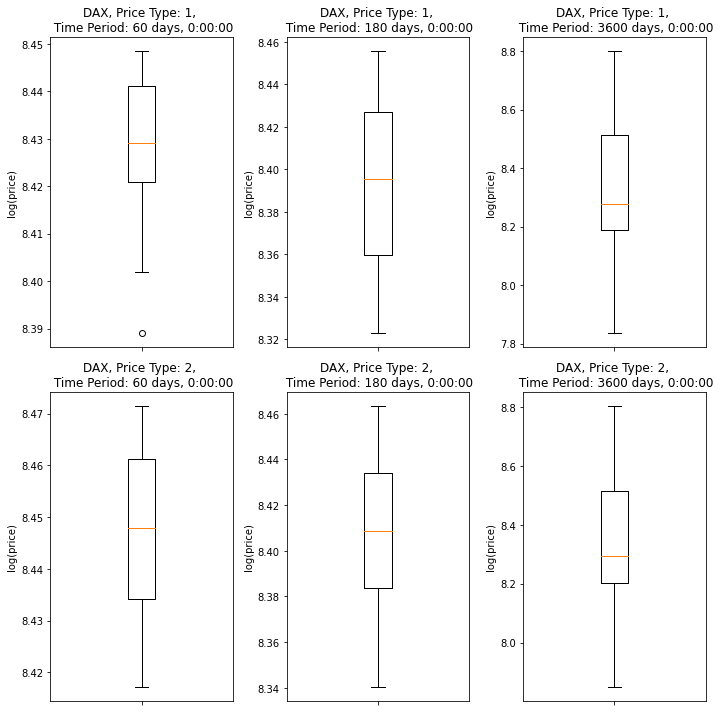

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))  # Create figure and axes for side by side plots

r = 0 
c = 0
for priceT in myPriceTypes:
    for timeP in myTimeP:
        currCollIndex = symbolsMap.get(myIndex)
        currSortedColl = []
        currColl = sortedBars[currCollIndex]  # Current collection of bars for the current index
        if timeP != 0:
            timePColl = []
            endTimeP = datetime.strptime(currColl[0].date, '%Y%m%d') + timeP
            for bar in currColl:  # Iterate through curr collection and only get bars within current time frame
                if (datetime.strptime(bar.date, '%Y%m%d')) < endTimeP:
                    timePColl.append(bar)
                else:
                    break  # Can just break since we have a sorted list
        else:
            timePColl = currColl  # Use all bar data for time period 0
        currSortedColl.append(timePColl)
        myCalcPrices = getCalcPriceBars(currSortedColl, priceT)
        calcCagrColl = cagrSortedBars(currSortedColl, myCalcPrices)
        
        axes[r, c].boxplot(np.log(calcCagrColl[0]))  # Apply lognormal transformation for easier interpretation.
        bTitleStr = myIndex + ", Price Type: " + str(priceT) + ", \n Time Period: " + str(timeP)
        axes[r, c].set(xticklabels=[], title = bTitleStr, ylabel="log(price)")
        
        c = c + 1
    c = 0  # Reset column index
    r = r + 1 
fig.tight_layout()

From the box plots above, we can see that both the 60 and 180 day box plot distributions look fairly normal. The quartiles are symmetric and the whiskers are fairly proportionate, except for 60 days price type 1. So, while the distributions for price types 1 and 2 for a period of 180 days look fairly similar, for 60 days, price type 2 looks a bit more normal. Price type 2 uses just the close price of the bar. <br> For the larger time periods, the data is more heavily left skewed. However, the whiskers appear very equal in length. This suggests that it does have some normal characteristics, which we seem to see in the histograms we explore next. 

**Histograms**

Then, another visual tool is used to check the normality - the histogram. We create the histograms using the code below.

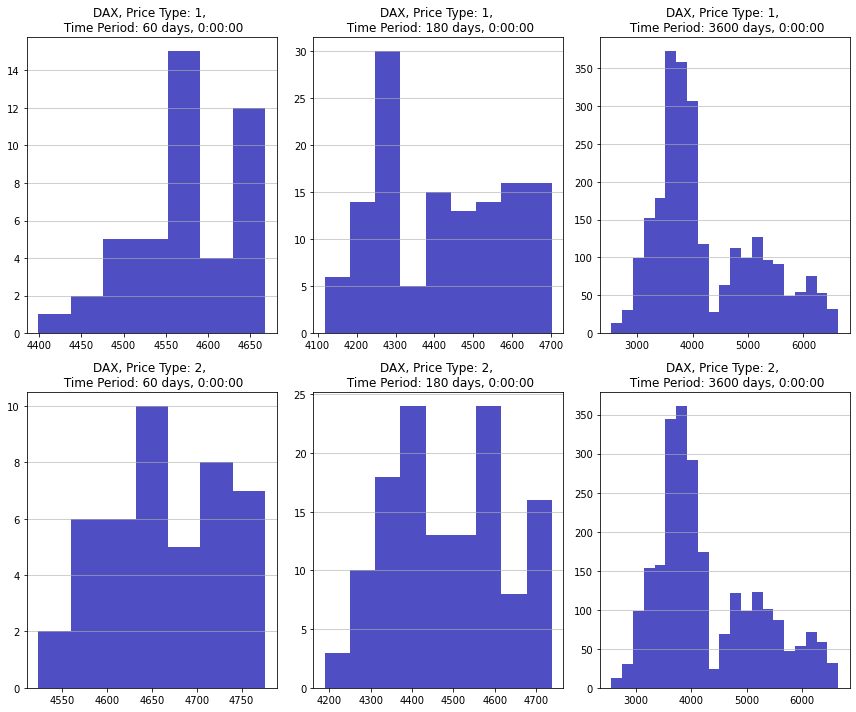

In [22]:
fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))  # Create figure and axes for side by side plots

r = 0 
c = 0
for priceT in myPriceTypes:
    for timeP in myTimeP:
        currCollIndex = symbolsMap.get(myIndex)
        currSortedColl = []
        currColl = sortedBars[currCollIndex]  # Current collection of bars for the current index
        if timeP != 0:
            timePColl = []
            endTimeP = datetime.strptime(currColl[0].date, '%Y%m%d') + timeP
            for bar in currColl:  # Iterate through curr collection and only get bars within current time frame
                if (datetime.strptime(bar.date, '%Y%m%d')) < endTimeP:
                    timePColl.append(bar)
                else:
                    break  # Can just break since we have a sorted list
        else:
            timePColl = currColl  # Use all bar data for time period 0
        currSortedColl.append(timePColl)
        myCalcPrices = getCalcPriceBars(currSortedColl, priceT)
        calcCagrColl = cagrSortedBars(currSortedColl, myCalcPrices)
        
        axes2[r, c].hist(x=calcCagrColl[0], bins='auto', color='#0504aa', alpha=0.7) 
        bTitleStr = myIndex + ", Price Type: " + str(priceT) + ", \n Time Period: " + str(timeP)
        axes2[r, c].grid(axis='y', alpha=0.75)
        axes2[r, c].set(title = bTitleStr)
        
        c = c + 1
    c = 0  # Reset column index
    r = r + 1 
fig2.tight_layout()

With this visualization, we still see some lognormal distributions. However, this plot makes it seem as though there is much more variance for our 2 smaller time periods, that is they don't have a typical bell curve shape. Interestingly, when plotted, the 10 year data set does appear more clearly lognormal. However, in this case it is too left skewed, which we also concluded with the box plots.<br>

## Initial Model Exploration

For the model exploration, we will reduce our dataset based on our lognormality tests above. So, we will choose parameters which seem to yield a more lognormal distribution. In this case, we will filter our dataset for only the index DAX, a time period of 180 days, and we will only extract the close price for price type 2. <br><br>
Note that since this is only the initial exploration of possible models, the model derived here may NOT be so robust for out of sample data

In [23]:
model_timeP = timedelta(days=180)
model_data = (sql_data.loc[sql_data['symbol'] == 'DAX                 ']).reset_index(drop = True)  # Remember white spaces
time_begin = pd.to_datetime(model_data.loc[0, 'time'])
model_endTime = time_begin + model_timeP
model_data = model_data.loc[model_data['time'] < model_endTime]

model_data

,time,symbol,exchange,bar_size,open,high,low,close,volume,vwap,count
0,2005-06-28 00:00:00+00:00,DAX,DTB,1 day,4304,4573,4304,4569,0,0,1069
1,2005-06-29 00:00:00+00:00,DAX,DTB,1 day,4579,4597,4560,4583,0,0,2467
2,2005-06-30 00:00:00+00:00,DAX,DTB,1 day,4585,4607,4576,4594,0,0,2384
3,2005-07-01 00:00:00+00:00,DAX,DTB,1 day,4576,4624,4573,4623,0,0,2381
4,2005-07-04 00:00:00+00:00,DAX,DTB,1 day,4625,4627,4611,4624,0,0,1211
...,...,...,...,...,...,...,...,...,...,...,...
124,2005-12-19 00:00:00+00:00,DAX,DTB,1 day,5344,5358,5328,5332,0,0,2286
125,2005-12-20 00:00:00+00:00,DAX,DTB,1 day,5342,5369,5323,5355,0,0,2517
126,2005-12-21 00:00:00+00:00,DAX,DTB,1 day,5355,5403,5355,5389,0,0,2229
127,2005-12-22 00:00:00+00:00,DAX,DTB,1 day,5395,5411,5383,5410,0,0,2124


Now that we have our filtered dataset above, we may explicityly define our x and y variables for the model.

In [24]:
x_data = model_data["time"].values
y_data = model_data["close"].values

Before proceeding further, plot the x and y data so that we can visually determine the type of model that may fit this data.

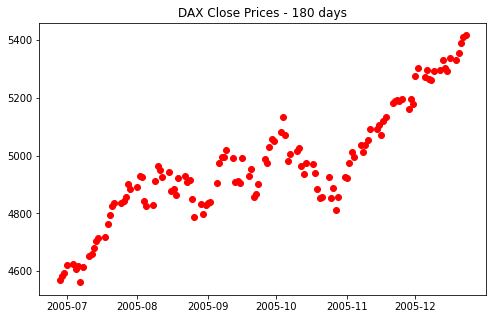

In [25]:
plt.figure(figsize=(8,5))
plt.title("DAX Close Prices - 180 days")
plt.plot(x_data, y_data, 'ro')

Then, we can define our training data. As this model is only for exploration, we will use all of our sample data. <br>
Otherwise, the data would have been split into more conventional train and test sets.

In [29]:
train_y = np.asanyarray(model_data[['close']])
x = mdates.date2num(model_data[['time']])
train_x = np.asanyarray(x)

As can be seen above, the data continuously increases with some peaks and valleys in between. Even though some of the peaks and valleys are a bit steep, this is visually similar to a polynomial model. <br><br>
As such, we will will use a **polynomial regression model** 

There appear to be a total of 6 valleys and peaks. So one would typically use a polynomial of degree 7. However, such a model may produce overfitting and may be computationally intense. Since the volatility does not appear that high, in this study we will use an estimation with a **3rd degree polynomial**. <br><br>
Below we transform the data

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [31]:
poly = PolynomialFeatures(degree=3)
train_y_poly = poly.fit_transform(train_y)
train_x_poly = poly.fit_transform(train_x)

Then, the linear regression model is fit using our transformed train data. <br><br> 
We may also print the coefficients and intercept of the model

In [32]:
clf2 = linear_model.LinearRegression()
train_y_ = clf2.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf2.coef_)
print ('Intercept: ',clf2.intercept_)

Coefficients:  [[ 0.00000000e+00  2.89884648e+05 -2.22189479e+01  5.67677082e-04]]
Intercept:  [-1.26067992e+09]


Then, we may compare our model to the actual values in a scatter plot as shown below

Text(0, 0.5, 'Price')

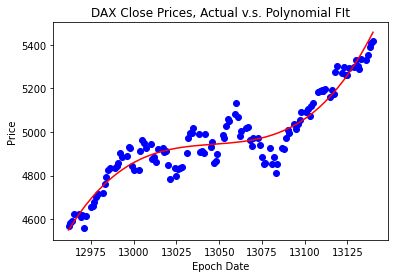

In [33]:
plt.scatter(x, train_y,  color='blue')

yy = clf2.intercept_[0]+ clf2.coef_[0][1]*x+ clf2.coef_[0][2]*np.power(x, 2)+ clf2.coef_[0][3]*np.power(x, 3)
plt.plot(x, yy, '-r' )
plt.title("DAX Close Prices, Actual v.s. Polynomial FIt")
plt.xlabel("Epoch Date")
plt.ylabel("Price")

The model visually looks moderately accurately. It accurately captures the upward trend, and some of the declines and recoveries. However, as expected, the model is not able to capture all the peaks and valleys. <br><br> This initial model just shows the type of price movement for the DAX index. Overall it has a somewhat polynomial shape, with a certain number of peaks and valleys. <br><br> In future model explorations, it would be interesting to see how the 'degree' of lognormality of a price dataset affects the model predictions that can be made. <br><br> This study did show either the close prices by themselves or the typical prices of an index seem to have the most lognormal distribution. In addition, it seems the German index, DAX, is the most lognormal. When exploring these findings further, they could also help to find the conditions that yield the most lognormal price dataset.

## References 

1. https://sixfigureinvesting.com/2018/11/predicting-price-ranges-with-historic-volatility/
2. https://www.macroption.com/calculating-moving-average-prices/
3. https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
4. https://www.r-bloggers.com/2011/10/normality-tests-don%e2%80%99t-do-what-you-think-they-do/
5. https://interactivebrokers.github.io/tws-api/historical_bars.html